# 直接对Bert+IP特征进行多分类

In [3]:
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
from mlp import mlp
import torch
import pandas as pd
# precess training data
train_ft=torch.load('./url/ip/features_train.pt')
url_ft=pd.read_csv('./url/ip/feature_train.csv')
ip_ft=pd.read_csv('./url/ip/ip_train.csv')
ip_ft=ip_ft.iloc[:,5:].to_numpy()
url_ft=url_ft.iloc[:,:7].to_numpy()
url_ft.shape
train_ft=np.concatenate([train_ft.numpy(),url_ft,ip_ft],axis=-1)
train_label=pd.read_csv('./url/ip/train_label.csv')
train_label.value_counts()
train_ft.shape

(3859, 778)

In [3]:
train_label.value_counts()

label
2        1905
6         903
4         580
8         228
9         149
3          37
11         28
10         17
1           5
7           5
5           1
12          1
dtype: int64

In [4]:
def eval_on_test(net,features,labels):
    net.eval()
    global highest_record
    length=len(labels)
    labels=DataLoader(labels,batch_size=64)
    features=DataLoader(features,batch_size=64)
    sum=0
    for feature,label in zip(features,labels):
        output=net(feature)
        predict=torch.argmax(output,dim=-1)
        sum+=(predict==label).sum()
    if sum>highest_record:
        print(f'new record:{sum}')
        highest_record=sum
        torch.save(net.state_dict(),'./classifier_model/ablation_best_mlp_ip.pkl')
    print(f"accuracy on test :{sum}/{length}={sum/length}")

In [12]:
def train(lr,batch_size,epoches,features_data,labels_data,test_features,test_labels,over_write=False):
    # load data
    labels=DataLoader(labels_data,batch_size=batch_size)
    features=DataLoader(features_data,batch_size=batch_size)
    # features_data=text_features
    print(features_data.shape)
    # !!!net and solver
    net=mlp(in_features=features_data.shape[-1])

    if os.path.exists('./classifier_model/ablation_mlp_ip.pkl') and not over_write:
        state_dict=torch.load('./classifier_model/ablation_mlp_ip.pkl')
        net.load_state_dict(state_dict=state_dict)
    criterion=torch.nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    # train
    loss_list=[]
    for e in range(epoches):
        epoch_loss=[]
        for label,feature in zip(labels,features):
            net.train()
            output=net(feature)
            loss=criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        eval_on_test(net,features=test_features,labels=test_labels)
        mean_loss=np.array(epoch_loss).mean()
        loss_list.append(mean_loss)
        print(f'epoch {e+1} loss: {mean_loss}')
    loss_log=pd.DataFrame(loss_list,columns=['loss'])
    if os.path.exists('./log/loss_ip.csv') and not over_write:
        f=pd.read_csv('./log/loss_ip.csv')
        loss_log=pd.concat([f,loss_log],axis=0)
    loss_log.to_csv('./log/loss_ip.csv',index=None)
    torch.save(net.state_dict(),'./classifier_model/ablation_mlp_ip.pkl')


In [6]:
test_ft=torch.load('./url/ip/features_test.pt')
test_url_ft=pd.read_csv('./url/ip/feature_test.csv')
test_ip_ft=pd.read_csv('./url/ip/ip_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ip_ft=test_ip_ft.iloc[:,5:].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft,test_ip_ft],axis=-1)
test_label=pd.read_csv('./url/ip/test_label.csv')
test_label.value_counts()
test_ft.shape

(868, 778)

In [7]:
test_label.value_counts()

label
2        429
6        204
4        125
8         54
9         40
3          7
1          2
7          2
10         2
12         2
11         1
dtype: int64

In [9]:
highest_record=0

In [18]:
train(lr=5e-6,
      batch_size=32,
      epoches=10,
      features_data=torch.tensor(train_ft,dtype=torch.float32),
      labels_data=train_label['label'],
      test_features=torch.tensor(test_ft,dtype=torch.float32),
      test_labels=test_label['label'],
      over_write=False)

torch.Size([3859, 778])
accuracy on test :866/868=0.9976958632469177
epoch 1 loss: 0.0046817101762172564
accuracy on test :866/868=0.9976958632469177
epoch 2 loss: 0.005265115986231115
accuracy on test :866/868=0.9976958632469177
epoch 3 loss: 0.005121668090785248
accuracy on test :866/868=0.9976958632469177
epoch 4 loss: 0.0030055865223865353
accuracy on test :866/868=0.9976958632469177
epoch 5 loss: 0.00452202217291956
accuracy on test :866/868=0.9976958632469177
epoch 6 loss: 0.0034763844307521183
accuracy on test :866/868=0.9976958632469177
epoch 7 loss: 0.004222350652360712
accuracy on test :866/868=0.9976958632469177
epoch 8 loss: 0.0028702977352690487
accuracy on test :866/868=0.9976958632469177
epoch 9 loss: 0.0036879228811046256
accuracy on test :866/868=0.9976958632469177
epoch 10 loss: 0.0025829332495897524


In [18]:
import joblib
from mlp import mlp
import torch
import pandas as pd
cls=mlp(in_features=778)
state_dict=torch.load('./classifier_model/ablation_best_mlp_ip.pkl')
cls.load_state_dict(state_dict=state_dict)
test_ft=torch.load('./url/ip/features_test.pt')
print(test_ft.shape)
test_url_ft=pd.read_csv('./url/ip/feature_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
print(test_url_ft.shape)
test_ip_ft=pd.read_csv('./url/ip/ip_test.csv')
test_ip_ft=test_ip_ft.iloc[:,5:].to_numpy()
print(test_ip_ft.shape)
test_ft=np.concatenate([test_ft.numpy(),test_url_ft,test_ip_ft],axis=-1)
print(test_ft.shape)
final_predict=cls(torch.tensor(test_ft,dtype=torch.float32))

torch.Size([868, 768])
(868, 7)
(868, 3)
(868, 778)


### 绘制混淆矩阵

In [19]:
final_predict.shape

torch.Size([868, 13])

In [20]:
import matplotlib.pyplot as plt
def draw_confusion_matrix(label,pred):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    c=confusion_matrix(label, pred)
    labels=list(set(label)|set(pred))
    print(labels)
    sns.heatmap(data=c,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
    plt.savefig('./img/bert_ip_mlp_confusion_matrix.png',dpi=720)

In [21]:
final_prediction=torch.argmax(final_predict,dim=-1)
ana=pd.DataFrame(final_prediction.detach(),columns=['label'])
test_ip_ft=pd.read_csv('./url/ip/ip_test.csv')
text=test_ip_ft['text']
text=[i[:100] for i in text]
text=pd.DataFrame(text,columns=['text'])
val=pd.concat([ana,text],axis=1)
val.to_csv('./url/ip/ablation_validation.csv',index=None)

In [22]:
final_prediction

tensor([ 2,  2,  9,  2,  6,  2,  2,  2,  2,  8,  2,  4,  8,  8,  6,  6,  4,  8,
         6,  9,  2,  2,  8,  4,  6,  6,  2,  2,  2,  2,  2,  2,  2,  4,  4,  2,
         4,  4,  6,  4,  4,  6,  6,  2,  2,  2,  4,  6,  2,  8,  2,  2,  2,  2,
         2,  3,  6,  2,  4,  4,  6,  2,  2,  2,  6,  6,  4,  2,  6,  2,  6,  4,
         3,  2,  6,  8,  8,  4,  2,  4,  2,  6,  2,  1,  2,  2,  2,  8,  2,  2,
         6,  2,  2,  6,  2,  6,  6,  4,  6,  6,  2,  6,  2,  8,  6,  6,  2,  6,
         8,  8,  2,  8,  8,  2,  4,  2,  9,  2,  2,  2,  4,  6,  6,  2,  2,  4,
         6,  2,  2, 11,  4,  4,  9,  2,  2,  6,  2,  4,  2,  2,  6,  2,  6,  2,
         6,  2,  2,  2,  2,  2, 11,  2,  2,  6,  2,  2,  4,  9,  2,  2,  9,  2,
         4,  6,  2,  6,  4,  4,  4,  2,  6,  4,  2,  2,  6,  4,  2,  2,  2,  6,
         4,  4,  6,  2,  2,  4,  2,  2,  2,  2,  2,  4,  4,  2,  4,  4,  6,  2,
         2,  2,  2,  2,  6,  6,  6,  2,  2,  4,  6,  2,  9,  4,  6,  4,  4,  2,
         2,  2,  6,  6,  6,  4,  2,  2, 

In [24]:
test_label=pd.read_csv('./url/ip/test_label.csv')
# test_label=pd.read_csv('./url/ip/test_label.csv')
right=(test_label['label']==final_prediction.numpy()).sum()
# length=len(final_prediction)
# print(f'{right}/{length}={right/length}')
right

863

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12]


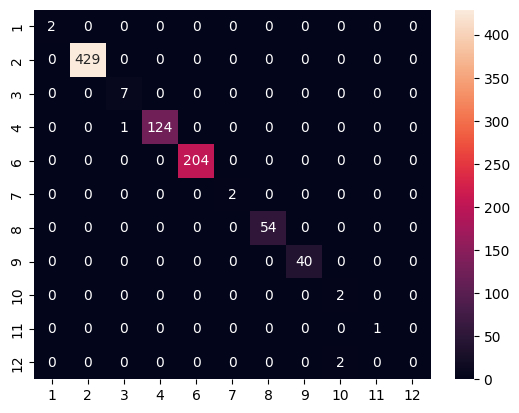

In [17]:
draw_confusion_matrix(test_label['label'].to_numpy(),final_prediction.numpy())